# Intorduction

In [ ]:
# Setup
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt


In [ ]:
# Avoid OMM Error
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
# check the GPU
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# define the images directory
data_dir = "/kaggle/input/potato-disease-leaf-datasetpld/PLD_3_Classes_256"
print(os.listdir(data_dir))

['Validation', 'Training', 'Testing']


In [ ]:
# let`s make EDA for the dataset
data_splits = os.listdir(data_dir)
for data_kind in data_splits:
    classes = os.listdir(os.path.join(data_dir,data_kind))
    print(f'*We Process the {data_kind}')
    for class_ in classes:
        path = os.path.join(os.path.join(data_dir,data_kind),class_)
        print(f'  we have a {len(os.listdir(path))} images from class {class_}')
    print('')


*We Process the Validation
  we have a 151 images from class Late_Blight
  we have a 163 images from class Early_Blight
  we have a 102 images from class Healthy

*We Process the Training
  we have a 1132 images from class Late_Blight
  we have a 1303 images from class Early_Blight
  we have a 816 images from class Healthy

*We Process the Testing
  we have a 141 images from class Late_Blight
  we have a 162 images from class Early_Blight
  we have a 102 images from class Healthy



In [ ]:
# Filter out Corrupted images

num_skipped = 0
data_splits = os.listdir(data_dir)

for data_kind in data_splits:
    data_kind_path = os.path.join(data_dir,data_kind)
    print(f'*We Process the {data_kind}')
    
    classes = os.listdir(data_kind_path)
    for class_ in classes:
        folder_path = os.path.join(data_kind_path,class_)
        for fname in os.listdir(folder_path):
            fpath = os.path.join(folder_path,fname)

            try:
                fobj = open(fpath,"rb")
                is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
            finally:
                fobj.close()

            if not is_jfif:
                num_skipped += 1
                os.remove(fpath)
    print(f"  Deleted {num_skipped} Images for {data_kind}\n")


*We Process the Validation
  Deleted 0 Images for Validation

*We Process the Training
  Deleted 0 Images for Training

*We Process the Testing
  Deleted 0 Images for Testing



# Genrate a Dataset and Visualize

In [ ]:
# load data with tf.utils.image_dataset_from_directory
IMAGE_SIZE = (256,256)
BATCH_SIZE = 16
SEED = 42

# make train-testing-validation datasets
def load_data(data_dir):
    data = []
    for class_d in os.listdir(data_dir):
        data.append(
            tf.keras.utils.image_dataset_from_directory(
            os.path.join(data_dir,class_d),
            image_size = IMAGE_SIZE,
            batch_size = BATCH_SIZE,
            seed = SEED)
                   )
    return data
# apllying the Load dataset
test_ds, train_ds, val_ds = load_data(data_dir)


Found 416 files belonging to 3 classes.
Found 3251 files belonging to 3 classes.
Found 405 files belonging to 3 classes.


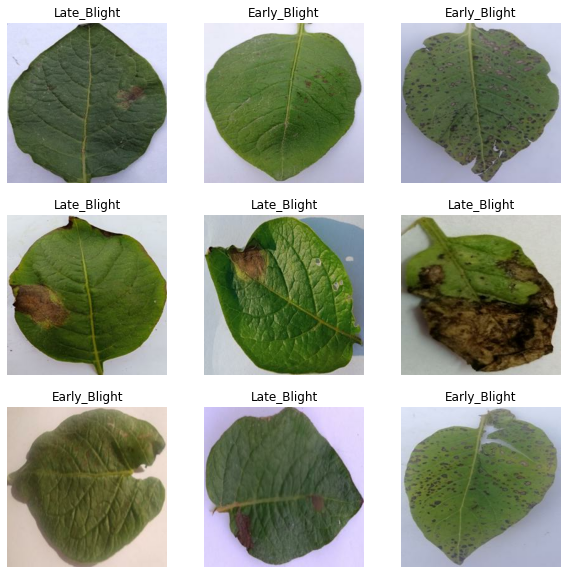

In [ ]:
# plot Visualize 
plt.figure(figsize=(10,10))
for image, label in test_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(train_ds.class_names[label[i]])
        plt.axis("off");
        

## Standardize the data

In [ ]:
# standardize values to be in the [0,1] range
normalization_layer = tf.keras.layers.Rescaling(1./255)

# using thr Dataset.map to apply this layer
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

# check pixels after normalization
images_batch, label_batch = next(iter(normalized_ds))
random_image = images_batch[4]
print(f' min value = {np.min(random_image)} , max value =  {np.max(random_image)}')

 min value = 0.0 , max value =  1.0


# Configure the dataset for performance


In [ ]:
# make sure to use buffered prefetching , yield the data without having I/O become bloking
def Configure(dataset):
    dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# apply the function
train_ds = Configure(train_ds)
val_ds = Configure(val_ds)


# Build a Model

In [ ]:
# build a small version of the `Xception Network`

NUM_CLASSES = 3
INPUT_SHAPE = IMAGE_SIZE +(3,)
model = tf.keras.Sequential([
    
    # rescaling and Data augmentation block
    tf.keras.layers.RandomFlip("horizontal_and_vertical", input_shape=INPUT_SHAPE),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.Rescaling(1.0/255),
    
    # Conv2D Block
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    
    # Flatten Block
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    
])    

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, 256, 256, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 256, 256, 3)       0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      1

In [ ]:
# Compile the Model  
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy'])

In [ ]:
# training the model
EPOCHS = 50
history = model.fit(
                    train_ds,
                    validation_data=val_ds,
                    epochs =EPOCHS)

Epoch 1/50
204/204 [==============================] - 9s 32ms/step - loss: 1.0403 - accuracy: 0.4389 - val_loss: 0.9490 - val_accuracy: 0.6420
Epoch 2/50
204/204 [==============================] - 4s 21ms/step - loss: 0.9583 - accuracy: 0.5617 - val_loss: 0.9128 - val_accuracy: 0.6099
Epoch 3/50
204/204 [==============================] - 4s 21ms/step - loss: 0.7922 - accuracy: 0.6721 - val_loss: 0.6167 - val_accuracy: 0.7481
Epoch 4/50
204/204 [==============================] - 4s 21ms/step - loss: 0.5824 - accuracy: 0.7693 - val_loss: 0.5168 - val_accuracy: 0.8049
Epoch 5/50
204/204 [==============================] - 4s 21ms/step - loss: 0.4356 - accuracy: 0.8364 - val_loss: 0.3916 - val_accuracy: 0.8815
Epoch 6/50
204/204 [==============================] - 4s 21ms/step - loss: 0.2786 - accuracy: 0.9010 - val_loss: 0.3222 - val_accuracy: 0.9062
Epoch 7/50
204/204 [==============================] - 4s 22ms/step - loss: 0.2384 - accuracy: 0.9197 - val_loss: 0.2327 - val_accuracy: 0.9235

# Model Evaluation

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])



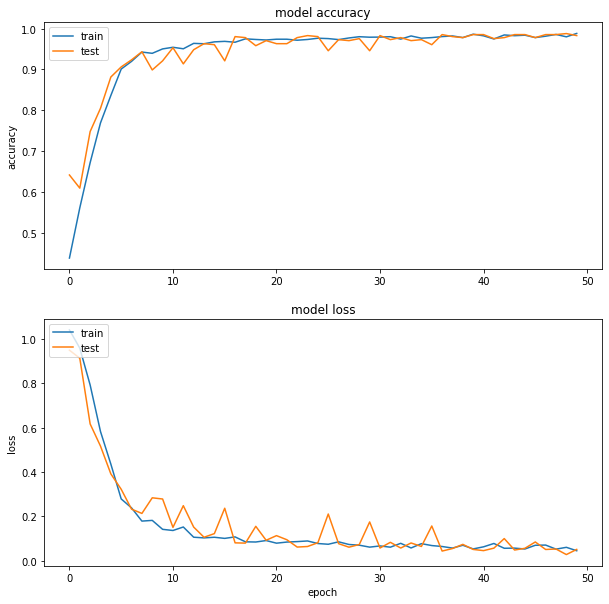

In [ ]:
# list all data in history
print(history.history.keys())
print("")
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# evalute model
model.evaluate(test_ds)

26/26 [==============================] - 1s 18ms/step - loss: 0.0311 - accuracy: 0.9880


[0.031121401116251945, 0.9879807829856873]

In [ ]:
# To Color The Output
from termcolor import colored

The Real Image was:  {'Early_Blight'} 



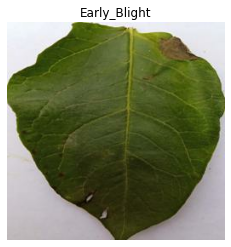


The Model Prediction was: 

(16, 256, 256, 3)

Class From Model Prediction is : {'Early_Blight'}  with confidence = {'99.86 %'}


In [ ]:
# ok everythink look nice, let`s check pic manually
for image_batch, label_batch in test_ds.take(1):
    idx = np.random.randint(0,15)
    print(f"The Real Image was: ",colored({test_ds.class_names[label[idx]]}, 'red'),"\n")
    plt.imshow(image_batch[idx].numpy().astype('uint8'))
    plt.title(test_ds.class_names[label[idx]])
    plt.axis("off");
    plt.show()
    
    print(f"\nThe Model Prediction was: \n")
    print(image_batch.shape)
    pred = model.predict(image_batch)
    pred_idx = np.argmax(pred[idx])
    confidence = str(round(100*(np.max(pred[idx])), 2)) + " %"
    print("")
    print("Class From Model Prediction is :",colored({test_ds.class_names[label[pred_idx]]}, 'green')," with confidence =",colored({confidence},'yellow'))

    

In [ ]:
# saving the model
model.save('./model_kentang_new.h5')

# Convert to ONNX

In [ ]:
# # Convert to ONNX using the Python API
# !pip install tf2onnx onnxruntime
# import tf2onnx
# import onnxruntime as rt

# spec = (tf.TensorSpec((None, 256, 256, 3), tf.float32, name="input"),)
# output_path = model.name + ".onnx"

# model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13, output_path=output_path)
# output_names = [n.name for n in model_proto.graph.output]

In [ ]:
# # Convert to ONNX using the command line

# !python3 -m tf2onnx.convert --opset 13 \
#     --saved-model {os.path.join("","save_model" )} \
#     --output  {os.path.join("save_model", model.name + ".onnx")}

In [ ]:
path = os.path.join("/save_model", model.name + ".onnx")
print(path)